In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.io as sio
import os
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import svm
from sklearn.externals import joblib

In [114]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [163]:
plt.savefig?

In [26]:
# Get list of models
model_name='model_sbox'
path_dict=ief.get_path_dict()
model_path=os.path.join(path_dict['szr_ant_root'],'MODELS',model_name)
model_list=[]
for f in os.listdir(model_path):
    if f.endswith('.pkl'):
        model_list.append(f)

        
n_models=len(model_list)
print('%d models found' % n_models)
print(model_list)

8 models found
['model0.pkl', 'model1.pkl', 'model2.pkl', 'model3.pkl', 'model4.pkl', 'model5.pkl', 'model6.pkl', 'model7.pkl']


In [8]:
# Import held sub data
sub='NA'

# Get list of features to use:
ftr_types=[]
ftr_fname='ftr_list_lap.txt'
print('Importing list of features to use from %s' % ftr_fname)
text_file = open(ftr_fname, 'r')
list1 = text_file.readlines()
for temp_ftr in list1:
    ftr_types.append(temp_ftr.rstrip())
print('Features being used: {}'.format(ftr_types))


Importing list of features to use from ftr_list_lap.txt
Features being used: ['PWR', 'PWR_3SEC', 'VLTG']


In [158]:
# Get list of data files for this sub
n_ftr_types=len(ftr_types)
n_dim=0
n_wind_list=[]
stem_list=[]
grand_ftr_list=[]
for type_ct, ftr_type in enumerate(ftr_types):
    print('Checking dimensions of feature type %s' % ftr_type)
    # Figure out how much data there is to preallocate mem
    ftr_type_dir=os.path.join(path_dict['ftrs_root'],ftr_type)

    if type_ct==0:
        # count time windows and create fname_stem_list
        stem_list = []
        ftr_path=os.path.join(ftr_type_dir,sub)
        for f in os.listdir(ftr_path):
            #get file stem
            f_parts = f.split('_')
            f_stem = f_parts[0]+'_'+f_parts[1]+'_'+f_parts[2]
            #fname_stem_list.append(f_stem)
            stem_list.append(f_stem)
            ftr_dict=np.load(os.path.join(ftr_path,f))
            #n_wind+=np.sum(ftr_dict['peri_ictal']>=0)
            n_wind_list.append(ftr_dict['ftrs'].shape[1])
    else:
        temp_n_wind=0
        f_ct=0
        # Load file extension
        ext_fname = os.path.join(ftr_type_dir, 'ext.txt')
        with open(ext_fname, 'r') as f_ext:
            ext = f_ext.readline()[:-1]
        print(ext_fname)
        print(ext)
        ftr_path=os.path.join(ftr_type_dir,sub)
        for temp_stem_ct, temp_stem in enumerate(stem_list):
            targ_file=os.path.join(ftr_path,temp_stem+ext)
            # if os.path.isfile(targ_file)==False:
            #     print('File not found: %s' % targ_file)
            #     raise ValueError('File stems do not match across features')
            print('Loading file %s' % targ_file)
            ftr_dict=np.load(targ_file)
            f_ct+=1
        if n_wind_list[temp_stem_ct]!=ftr_dict['ftrs'].shape[1]:
            raise ValueError('# of time windows do not match across features')
    n_dim += ftr_dict['ftrs'].shape[0]
    for ftr_label in ftr_dict['ftr_list']:
        grand_ftr_list.append(ftr_label)
    #grand_ftr_list.append(ftr_dict['ftr_list'])

print('Total # of dimensions: %d ' % n_dim)
print('Total # of time windows: {} '.format(n_wind_list))
print('Total # of files: %d' % f_ct)
print(grand_ftr_list)

Checking dimensions of feature type PWR
Checking dimensions of feature type PWR_3SEC
/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR_3SEC/ext.txt
_bppwr_3sec.npz
Loading file /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz2_bppwr_3sec.npz
Loading file /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz3_bppwr_3sec.npz
Loading file /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz4_bppwr_3sec.npz
Loading file /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz5_bppwr_3sec.npz
Loading file /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d2_sz1_bppwr_3sec.npz
Checking dimensions of feature type VLTG
/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/VLTG/ext.txt
_vltg.npz
Loading file /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/VLTG/NA/NA_d1_sz2_vltg.npz
Loading file /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/VLTG/NA/NA_d1_sz3_vltg.npz
Loading file /Users/davidgroppe/PycharmProjects/SZR_ANT/

Loading /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR/NA/NA_d1_sz2_bppwr.npz
Loading /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz2_bppwr_3sec.npz
Loading /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/VLTG/NA/NA_d1_sz2_vltg.npz
Applying model 1/8
Applying model 2/8
Applying model 3/8
Applying model 4/8
Applying model 5/8
Applying model 6/8
Applying model 7/8
Applying model 8/8
17 dimensions
1860 observations
Creating file /Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/model_sbox/PICS/NA_d1_sz2.jpg
Loading /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR/NA/NA_d1_sz3_bppwr.npz
Loading /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR_3SEC/NA/NA_d1_sz3_bppwr_3sec.npz
Loading /Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/VLTG/NA/NA_d1_sz3_vltg.npz
Applying model 1/8
Applying model 2/8
Applying model 3/8
Applying model 4/8
Applying model 5/8
Applying model 6/8
Applying model 7/8
Applying model 8/8
17 dimensions
2610 observations
Creating file /Users

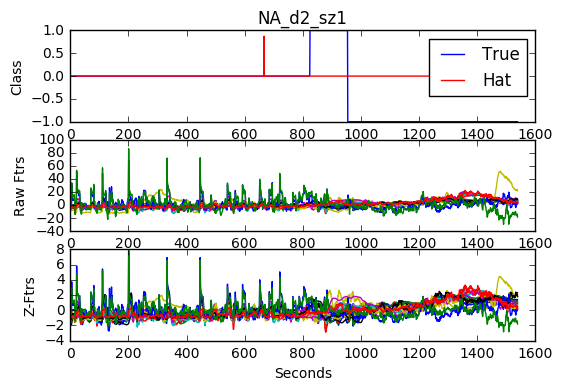

In [138]:
# Load validation data and calculate false positive rate, and peri-onset latency
onset_dif_sec_list=list()
n_missed_szrs=0
pptn_preonset_stim=0
mn_onset_dif=0
phat_list=[]
for stem_ct, stem_loop in enumerate(stem_list):
    # Collect features for each seizure
    dim_ct=0
    phat_list.append(np.zeros((n_wind_list[stem_ct],n_models)))
    for ftr_type in ftr_types:
        ftr_path = os.path.join(path_dict['ftrs_root'], ftr_type, sub)
        file_found=False
        for f_valid in os.listdir(ftr_path):
            # get file stem
            f_parts = f_valid.split('_')
            temp_f_stem = f_parts[0] + '_' + f_parts[1] + '_' + f_parts[2]
            if temp_f_stem==stem_loop:
                # load file
                #print('Loading %s' % f)
                print('Loading %s' % os.path.join(ftr_path, f_valid))
                ftr_dict = np.load(os.path.join(ftr_path, f_valid))
                file_found=True
                # break out of for loop
                break
        # Catch if new file was not loaded
        if not file_found:
            print('Trying to find %s for %s' % (stem_loop,ftr_type))
            print('Looking in dir %s' % ftr_path)
            raise ValueError('File stem not found')
            exit()
        # Add ftr to collection
        temp_n_dim = ftr_dict['ftrs'].shape[0]
        # Note that we use all time points (even ictal points long after ictal onset
        if ftr_type==ftr_types[0]:
            # First feature being analyzed pre-allocate mem
            temp_n_wind=ftr_dict['ftrs'].shape[1]
            temp_valid_ftrs=np.zeros((temp_n_wind,n_dim))
        temp_valid_ftrs[:, dim_ct:dim_ct + temp_n_dim] = ftr_dict['ftrs'].T
        dim_ct += temp_n_dim

    for model_ct in range(n_models):
        # Load model
        model_fname=os.path.join(model_path,model_list[model_ct])
        temp_model=joblib.load(model_fname)
        # Classify each time point
        print('Applying model %d/%d' % (model_ct+1,n_models))
        temp_class_hat=temp_model.predict(temp_valid_ftrs) 
        #temp_class_hat=rbf_svc.predict(temp_valid_ftrs)
        phat_list[stem_ct][:,model_ct]=temp_class_hat
    
    # Average predictions across all models and take the majority vote
    temp_class_hat=np.mean(phat_list[stem_ct],axis=1)
    temp_class_hat_bool=temp_class_hat>0.5
    plot_fig(ftr_dict['peri_ictal'],temp_class_hat,temp_valid_ftrs,stem_loop,stem_ct,model_path)
    
    # Compute latency of earliest ictal prediction relative to clinician onset
    sgram_srate=1/10
    onset_dif_sec, preonset_stim=ief.cmpt_postonset_stim_latency(temp_class_hat_bool,ftr_dict['peri_ictal'],sgram_srate)
    pptn_preonset_stim+=preonset_stim/f_ct
    if onset_dif_sec is None:
        # no positives during peri-onset time window
        n_missed_szrs+=1
    else:
        mn_onset_dif+=onset_dif_sec
    
pptn_missed_szrs = n_missed_szrs/f_ct
if n_missed_szrs==f_ct:
    mn_stim_latency = np.nan
else:
    mn_stim_latency= mn_onset_dif/(n_fct-n_missed_szrs)
    
print('Proportion of missed szrs: %f ' % pptn_missed_szrs)
print('Proportion of szrs with pre-onset stimulation: %f ' % pptn_preonset_stim)
print('Mean postonset stim latency %f' % mn_stim_latency)
out_fname=os.path.join(model_path,'smry.npz')
np.savez(out_fname,
         pptn_missed_szrs=pptn_missed_szrs,
         pptn_preonset_stim=pptn_preonset_stim,
         mn_stim_latency=mn_stim_latency,
         sub=sub,
         grand_ftr_list=grand_ftr_list)

In [165]:
# true_class=ftr_dict['peri_ictal']
# hat_class=temp_class_hat
# ftr_vals=temp_valid_ftrs

def plot_fig(true_class,hat_class,ftr_vals,stem,fig_ct,model_dir):
    plt.figure(1)
    plt.clf()
    plt.subplot(3,1,1)
    _=plt.plot(true_class,label='True')
    _=plt.plot(hat_class,'r',label='Hat')
    plt.ylabel('Class')
    plt.legend()
    plt.title(stem)

    plt.subplot(3,1,2)
    _=plt.plot(ftr_vals)
    plt.ylabel('Raw Ftrs')

    temp_valid_ftrs_z=np.copy(ftr_vals).T
    dg.normalize(temp_valid_ftrs_z)
    plt.subplot(3,1,3)
    _=plt.plot(temp_valid_ftrs_z.T)
    plt.xlabel('Seconds')
    plt.ylabel('Z-Ftrs')

    
    fig_path=os.path.join(model_path,'PICS')
    if os.path.exists(fig_path)==False:
        os.mkdir(fig_path)
    fig_fname=os.path.join(fig_path,stem+'.jpg')
    print('Creating file %s' % fig_fname)
    plt.savefig(fig_fname,format='jpg')

17 dimensions
1540 observations
Creating file /Users/davidgroppe/PycharmProjects/SZR_ANT/MODELS/model_sbox/PICS/NA_d2_sz1.jpg


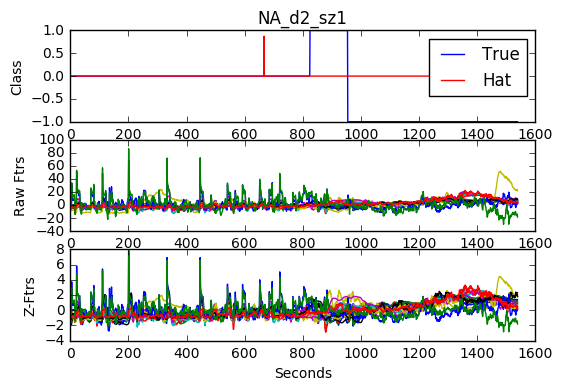

In [166]:
plot_fig(ftr_dict['peri_ictal'],temp_class_hat,temp_valid_ftrs,stem_loop,stem_ct,model_path)
    